The image is not confidently classified.


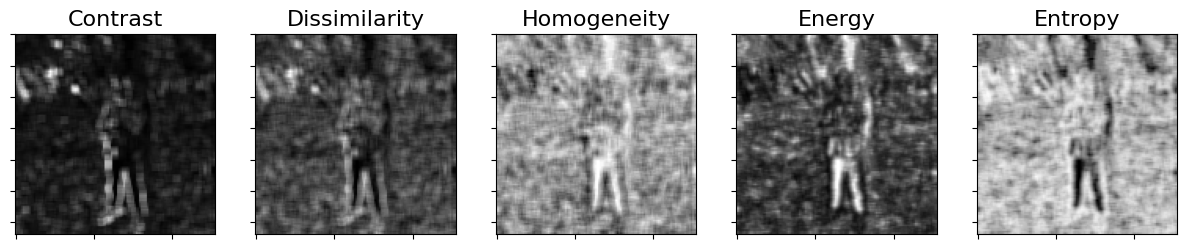

In [1]:
import numpy as np
import joblib
from PIL import Image
import cv2

from skimage.color import rgb2gray
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data

def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm



def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm contrast
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont


def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm dissimilarity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)

    return diss


def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo


def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene

def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent




def calculate_glcm_features(images):
    features = []
    # Resize image to reduce memory usage
    h,w = images.shape
    glcm_contrast = fast_glcm_contrast(images)
    glcm_dissimilarity = fast_glcm_dissimilarity(images)
    glcm_homogeneity = fast_glcm_homogeneity(images)
    glcm_asm, glcm_energy = fast_glcm_ASM(images)
    glcm_entropy = fast_glcm_entropy(images)

    features = np.concatenate([ glcm_contrast.ravel(),
                            glcm_dissimilarity.ravel(), glcm_homogeneity.ravel(),
                                glcm_energy.ravel(),
                            glcm_entropy.ravel()])
    fs = 16

    plt.figure(figsize=(15, 6))

    plt.subplot(2, 5, 1)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(glcm_contrast, cmap='gray')
    plt.title('Contrast', fontsize=fs)

    plt.subplot(2, 5, 2)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(glcm_dissimilarity, cmap='gray')
    plt.title('Dissimilarity', fontsize=fs)

    plt.subplot(2, 5, 3)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(glcm_homogeneity, cmap='gray')
    plt.title('Homogeneity', fontsize=fs)

    plt.subplot(2, 5, 4)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(glcm_energy, cmap='gray')
    plt.title('Energy', fontsize=fs)

    plt.subplot(2, 5, 5)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(glcm_entropy, cmap='gray')
    plt.title('Entropy', fontsize=fs)

    return np.array(features)

import numpy as np
import cv2
from PIL import Image

def predict_class_with_threshold(image_path):
    model_path = r'U:\GLCM\final\svm_model_final.pkl'
    target_names = ['Blight', 'Brownspot', 'blast']
    threshold=40
    # Load the saved model
    loaded_model = joblib.load(model_path)
    
    # Read and preprocess the new image
    new_img = np.array(Image.open(image_path).convert('L'))
    image_size = (128, 128)
    resizedimage = cv2.resize(new_img, image_size)
    
    # Calculate GLCM features for the new image
    new_image_features = calculate_glcm_features(resizedimage)  # Assuming this function is defined
    
    # Use the trained model to predict the class of the new image
    predicted_class = loaded_model.predict([new_image_features])[0]
    predicted_class_name = target_names[predicted_class]
    
    # Use the trained model to predict the class and obtain the decision function values
    decision_function_values = loaded_model.decision_function([new_image_features])
    
    # Compute the confidence score for the prediction
    confidence_score = np.abs(decision_function_values) / np.linalg.norm(loaded_model.coef_)
    
    # Get the maximum confidence score
    max_confidence = np.max(confidence_score)
    
    # Check if the maximum confidence score is above the threshold
    if max_confidence >= threshold:
        return predicted_class_name, max_confidence
    else:
        return None, None

# Example usage:
image_path = r"C:\Users\nitro\Desktop\1.jpg"
predicted_class, score = predict_class_with_threshold(image_path)

if predicted_class is not None:
    print(f"Predicted Class: {predicted_class}")
    print(f"Score: {score}")
else:
    print("The image is not confidently classified.")



